In [2]:
import palantir
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import scrublet as scr

import igraph
import loompy as lmp
import anndata

from pathlib import Path
import scvelo as scv
from scipy.stats import ranksums
scv.settings.set_figure_params("scvelo")

# Plotting 
import matplotlib
import matplotlib.pyplot as plt

sns.set_style('ticks')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Inline plotting
%matplotlib inline

# Reset random seed
np.random.seed(5)

In [3]:
# Set parameters for plots, including size, color, etc.
scv.set_figure_params(style="scvelo")
plt.rcParams["figure.figsize"] = (4,4)
Colorss=["#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00","#FFFF33","#A65628","#F781BF"]

In [3]:
#Low salt
DATA_DIR_low_salt = Path("./output_data_Tn/low_salt/") 
DATA_DIR_low_salt.mkdir(parents=True, exist_ok=True)

FILE_NAME_low_salt = DATA_DIR_low_salt / "low_salt.h5ad"

In [4]:
#High salt
DATA_DIR_high_salt = Path("./output_data_Tn/high_salt/") 
DATA_DIR_high_salt.mkdir(parents=True, exist_ok=True)

FILE_NAME_high_salt = DATA_DIR_high_salt / "high_salt.h5ad"

In [5]:
# Load 10X output
adata_low_salt = sc.read_10x_mtx(
    './raw_data/0172/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


# Read velocyto output
low_salt_velocyto = scv.read('./raw_data/0172/0172_sample_alignments.loom', cache=True)

scv.utils.clean_obs_names(adata_low_salt)
scv.utils.clean_obs_names(low_salt_velocyto)

# Merge velocyto with cellranger matrix
adata_low_salt = scv.utils.merge(adata_low_salt, low_salt_velocyto)

In [6]:
# Load 10X output
adata_high_salt = sc.read_10x_mtx(
    './raw_data/0173/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

# Read velocyto output
high_salt_velocyto = scv.read('./raw_data/0173/0173_sample_alignments.loom', cache=True)

scv.utils.clean_obs_names(adata_high_salt)
scv.utils.clean_obs_names(high_salt_velocyto)

# Merge velocyto with cellranger matrix
adata_high_salt = scv.utils.merge(adata_high_salt, high_salt_velocyto)

In [7]:
adata_low_salt
adata_low_salt.obs['Condition'] = 'Low NaCl'

In [8]:
adata_high_salt
adata_high_salt.obs['Condition'] = 'High NaCl'

In [9]:
#Concat high and low salt adata objects
adata_list = [adata_low_salt, adata_high_salt]
adata = sc.concat(adata_list, axis=0)

In [10]:
#doublet removal
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()

adata.obs['doublet_info'] = adata.obs['predicted_doublets']
adata = adata[adata.obs['doublet_info'] == False, :]

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 29.9 seconds


In [10]:
#preprocessing
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=10)

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_anndata.py:490: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


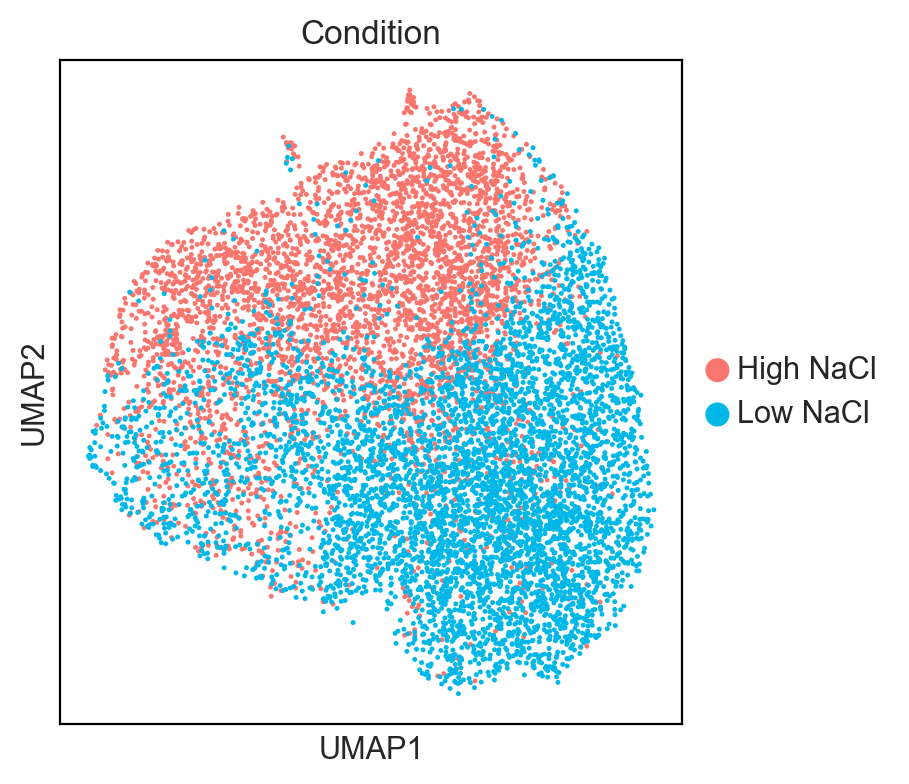

In [16]:
#UMAP
sc.tl.umap(adata)

sc.pl.scatter(
    adata,
    basis="umap",
    color="Condition",
    palette=["#F8766D", "#00B8E7"],
)

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


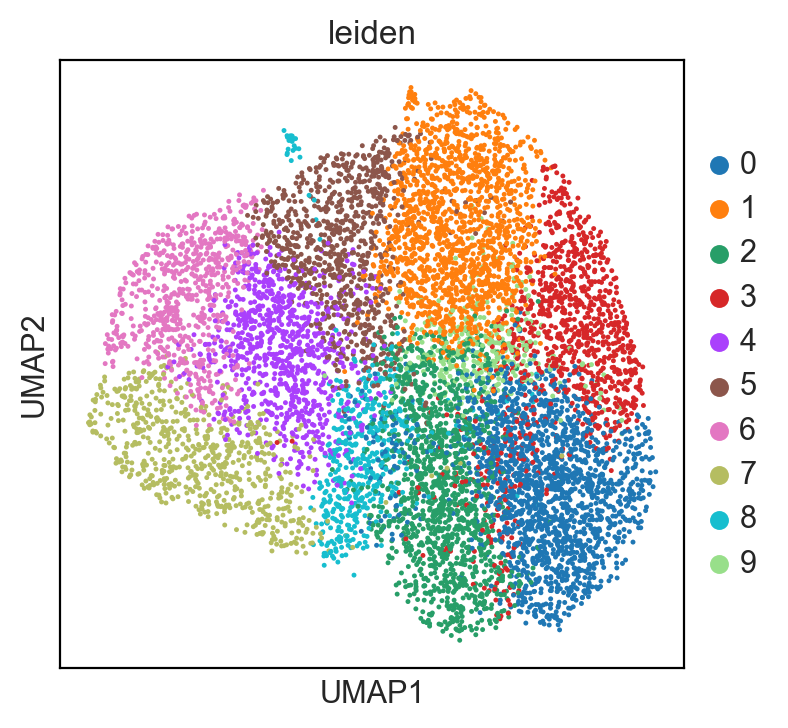

In [17]:
sc.tl.leiden(adata, resolution = 0.7)
sc.pl.umap(adata, color=['leiden'])

In [18]:
adata.write("combined_adata.h5ad")

In [4]:
adata = anndata.read_h5ad("./combined_adata.h5ad")

Velocity for high and low salt 

In [5]:
# Standard scvelo processing to run Dynamical Mode
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/20 cores)


  0%|          | 0/9508 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file ./figures/scvelo_scVelo-umap-cluster_high_and_low_salt.png


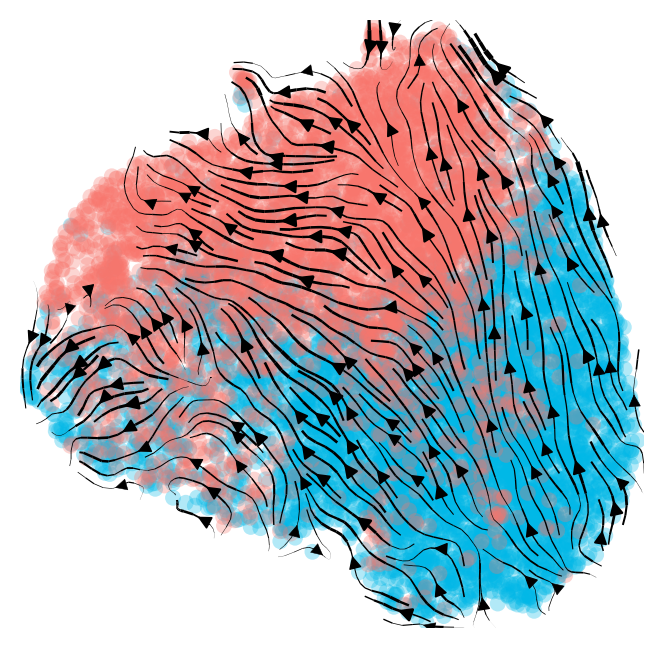

In [7]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="Condition", legend_loc= 'none', title="", save='scVelo-umap-cluster_high_and_low_salt.pdf')

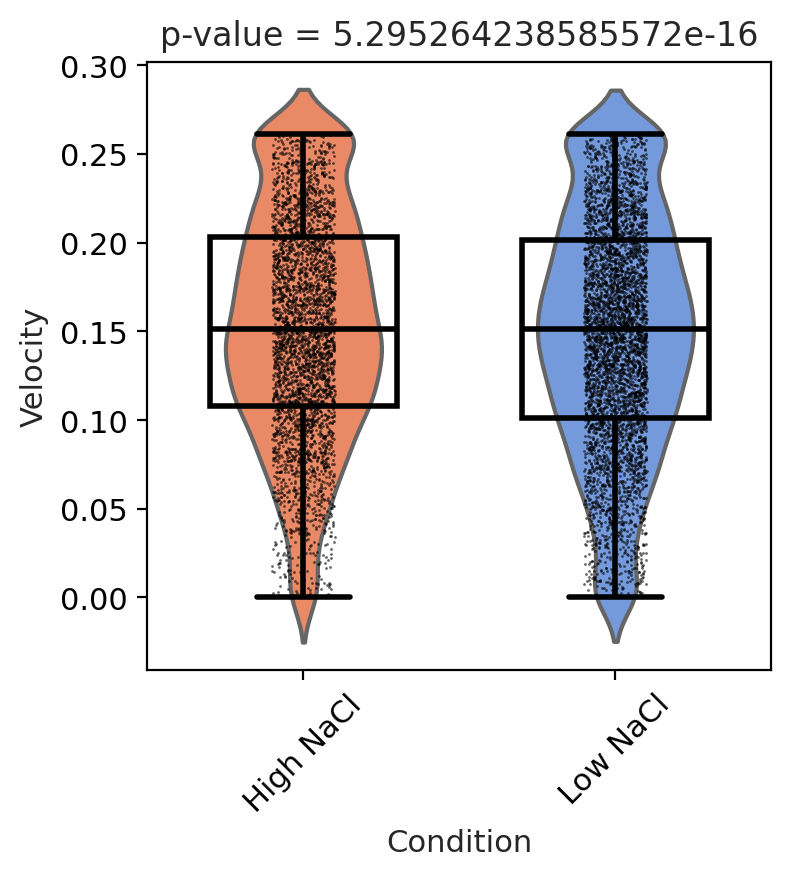

In [9]:
# Subset the data for the "high salt" and "low salt" conditions
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'High NaCl', 'velocity_self_transition']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'Low NaCl', 'velocity_self_transition']

# Create a DataFrame with the condition and velocity_self_transition columns
df = pd.DataFrame({
    'Condition': ['High NaCl'] * len(dpt_high_salt) + ['Low NaCl'] * len(dpt_low_salt),
    'velocity_self_transition': list(dpt_high_salt) + list(dpt_low_salt)
})

# Perform Wilcoxon rank sum test
statistic, p_value = ranksums(dpt_high_salt, dpt_low_salt)

# Set the figure size
plt.figure(figsize=(4, 4))

# Create the violinplot with custom colors
sns.violinplot(
    x="Condition",
    y="velocity_self_transition",
    data=df,
    inner=None,
    palette=['coral', 'cornflowerblue'],
    scale="count",
    width=0.5,
    linewidth=1.5
)

# Add jitter points
sns.stripplot(
    x="Condition",
    y="velocity_self_transition",
    data=df,
    jitter=True,
    color='black',
    alpha=0.6,
    size=1
)

# Create the boxplot
sns.boxplot(
    x="Condition",
    y="velocity_self_transition",
    data=df,
    width=0.6,
    color="black",
    fliersize=1,
    whis=5,
    linewidth=2,
    boxprops={'edgecolor': 'black', 'facecolor': 'None'},
    medianprops={'color': 'black', 'linewidth': 2}
)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Velocity")

# Add p-value as title
plt.title(f"p-value = 5.295264238585572e-16")

# Save the plot including the title
plt.savefig("scVelo-violin-boxplot-latent_time.pdf", bbox_inches="tight")

# Show the plot
plt.show()
